In [1]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from numpy import linspace, loadtxt, ones, convolve
from sklearn.ensemble import IsolationForest
import numpy as np
import pandas as pd
import collections
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
# style.use('fivethirtyeight')
from jupyterthemes import jtplot
jtplot.style(grid=False)

pd.set_option('display.max_columns', None)

%matplotlib inline

pd.plotting.register_matplotlib_converters()

Goal: Anomaly in number of web pages accessed in a day by a user. A bot copying curriculum? 

Before we look by user, let's make it work by analyzing over all users. 

In [2]:
#creating df from access logs
colnames = ['date', 'endpoint', 'user_id', 'cohort_id', 'source_ip']
df = pd.read_csv("anonymized-curriculum-access.txt", 
                 sep="\s", 
                 header=None, 
                 names = colnames, 
                 usecols=[0, 2, 3, 4, 5])
df.head()

,date,endpoint,user_id,cohort_id,source_ip
0,2018-01-26,/,1,8.0,97.105.19.61
1,2018-01-26,java-ii,1,8.0,97.105.19.61
2,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61


In [3]:
#changing index to date and resampling by day
df.date = pd.to_datetime(df.date)
df = df.set_index(df.date)
pages = df['endpoint'].resample('d').count()
pages.head()

date
2018-01-26    572
2018-01-27    230
2018-01-28    170
2018-01-29    830
2018-01-30    652
Freq: D, Name: endpoint, dtype: int64

<AxesSubplot:xlabel='date'>

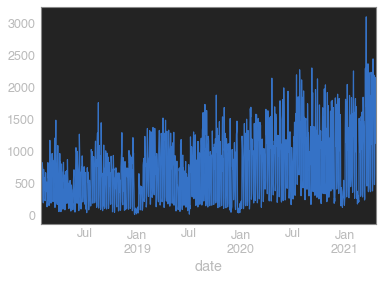

In [4]:
pages.plot()

No need to split because we are not modeling, we are using statistics to identify low probability cases. 

In [5]:
# end_train = '2020-06-30'
# start_test = '2020-07-01'

# train = pages[:end_train]
# test = pages[start_test:]

In [6]:
# plt.figure(figsize=(12, 6))
# plt.plot(train)
# plt.plot(test)
# plt.show()

In [7]:
pages.isnull().sum()

0

## Exponential Moving Average

SMA time series are much less noisy than the time series of the original data points. 
The challenge with SMA, however, is that the values of SMA lag the original values. This means that changes in the trend are only seen with a delay (lag) of L time units. 

Exponential Moving Average (EMA) helps reduce the lag induced by the use of the SMA. It does this by putting more weight on more recent observations, while the SMA weights all observations equally.

The EMA function looks like this: 

$EMA_{t}= \alpha * (t_{0} - EMA_{t-1}) + EMA_{t-1}$

Where: 

- M = Number of time periods, span of the window

- $t_{0}$ = Latest value

- $t-1$ = Previous value

- $EMA_{t-1}$ = Exponential moving average of previous day. 

- The multiplier: $\alpha = \frac{2}{M+1}$

However, we will use the pandas ewm (Exponential Weighted functions) to compute our EMA. 
So we just need to define the following: 

- M = `span` argument = number of time periods. We will try 7 days, 14 days, and 30 days. 

- Notice how there are no missing values. ewm() will use as many values are available to compute the mean. So if the span is 7 days, but it is on the first day of data available, the EMA will equal the first value. 

In [8]:
# 7 day EMA
ema_7d = pages.ewm(span=7).mean()
ema_7d.head()

date
2018-01-26    572.000000
2018-01-27    376.571429
2018-01-28    287.243243
2018-01-29    485.737143
2018-01-30    540.235595
Freq: D, Name: endpoint, dtype: float64

In [9]:
# 14 days EMA
ema_14d = pages.ewm(span=14).mean()
ema_14d.head()

date
2018-01-26    572.000000
2018-01-27    388.785714
2018-01-28    305.208829
2018-01-29    465.757252
2018-01-30    514.347700
Freq: D, Name: endpoint, dtype: float64

In [10]:
# 30 days EMA
ema_30d = pages.ewm(span=30).mean()
ema_30d.head()

date
2018-01-26    572.000000
2018-01-27    395.300000
2018-01-28    315.139578
2018-01-29    457.002386
2018-01-30    501.369064
Freq: D, Name: endpoint, dtype: float64

In [11]:
# 90 days EMA
ema_90d = pages.ewm(span=90).mean()
ema_90d.head()

date
2018-01-26    572.000000
2018-01-27    399.100000
2018-01-28    321.030081
2018-01-29    452.545042
2018-01-30    494.228442
Freq: D, Name: endpoint, dtype: float64

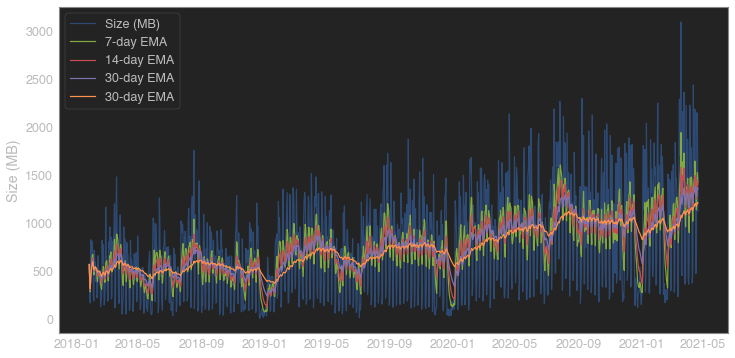

In [12]:
#plotting different period EMAs
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(pages.index, pages, label='Size (MB)', alpha=.5)

ax.plot(pages.index, ema_7d, label = '7-day EMA')
ax.plot(pages.index, ema_14d, label = '14-day EMA')
ax.plot(pages.index, ema_30d, label = '30-day EMA')
ax.plot(pages.index, ema_90d, label = '90-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')

plt.show()

## Bollinger Bands and %b

**Bollinger Bands**

- a volatility indicator and commonly used in stock market trading. 

- Made up of 3 lines, the Upper Band (UB), the Lower Band (LB) and the Midband.  

**Midband**

- The Exponential Moving Average

- `midband = train.ewm(span=30).mean()`

**Upper & Lower Band**

- UB/LB = Midband +/- stdev * K

- `stdev = train.ewm(span=30).std()` 

- K = the number of standard deviations to go up and down from the EMA

**%b, Percent Bandwidth**

- Shows where the last value sits in relation to the bands

- $\%b = \frac{last-LB}{UB-LB}$ 

- %b > 1 => point lies above UB

- %b < 0 => point lies below LB

- %b == .5 => point lies on the midband. 

**Bandwidth** 

- The width of the bands

- $Bandwidth = \frac{(UB-LB)}{Midband}$


In [13]:
# set the window span
span = 30

# compute midband
midband = pages.ewm(span=span).mean()

midband.head()

date
2018-01-26    572.000000
2018-01-27    395.300000
2018-01-28    315.139578
2018-01-29    457.002386
2018-01-30    501.369064
Freq: D, Name: endpoint, dtype: float64

In [14]:
# compute exponential stdev
stdev = pages.ewm(span=span).std()

stdev.head()

date
2018-01-26           NaN
2018-01-27    241.830519
2018-01-28    213.878138
2018-01-29    316.467837
2018-01-30    284.479727
Freq: D, Name: endpoint, dtype: float64

In [15]:
# compute upper and lower bands
ub = midband + stdev*3
lb = midband - stdev*3
ub

date
2018-01-26            NaN
2018-01-27    1120.791557
2018-01-28     956.773991
2018-01-29    1406.405897
2018-01-30    1354.808245
                 ...     
2021-04-17    3545.216722
2021-04-18    3486.733695
2021-04-19    3569.147958
2021-04-20    3579.231798
2021-04-21    3499.094360
Freq: D, Name: endpoint, Length: 1182, dtype: float64

In [16]:
lb

date
2018-01-26           NaN
2018-01-27   -330.191557
2018-01-28   -326.494835
2018-01-29   -492.401124
2018-01-30   -352.070116
                 ...    
2021-04-17   -894.858492
2021-04-18   -922.334061
2021-04-19   -891.999913
2021-04-20   -825.770723
2021-04-21   -777.340451
Freq: D, Name: endpoint, Length: 1182, dtype: float64

In [17]:
# concatenate ub and lb together into one df, bb
bb = pd.concat([ub, lb], axis=1)

bb.columns = ['ub', 'lb']
bb.head()

,ub,lb
date,,
2018-01-26,NaN,NaN
2018-01-27,1120.791557,-330.191557
2018-01-28,956.773991,-326.494835
2018-01-29,1406.405897,-492.401124
2018-01-30,1354.808245,-352.070116


In [18]:
train = pd.concat([pages, midband, bb], axis=1)
train.columns = ['pages', 'midband', 'ub', 'lb']
train.head()

,pages,midband,ub,lb
date,,,,
2018-01-26,572,572.000000,NaN,NaN
2018-01-27,230,395.300000,1120.791557,-330.191557
2018-01-28,170,315.139578,956.773991,-326.494835
2018-01-29,830,457.002386,1406.405897,-492.401124
2018-01-30,652,501.369064,1354.808245,-352.070116


Plot the bands

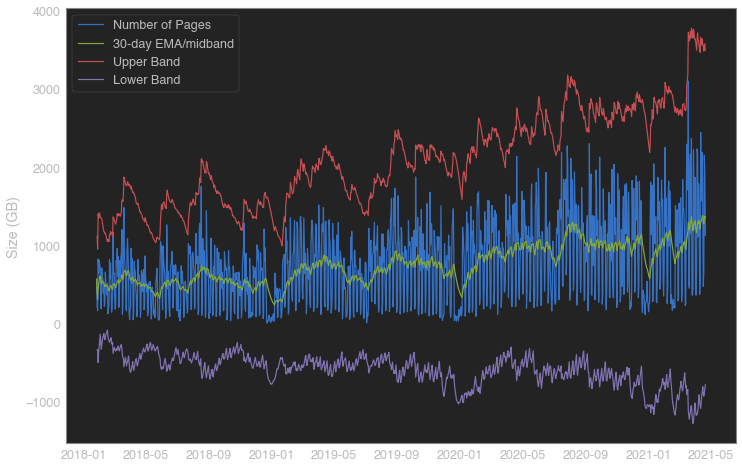

In [19]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(train.index, train.pages, label='Number of Pages')

ax.plot(train.index, train.midband, label = '30-day EMA/midband')
ax.plot(train.index, train.ub, label = 'Upper Band')
ax.plot(train.index, train.lb, label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Size (GB)')

plt.show()

Compute %b

$\%b = \frac{last-LB}{UB-LB}$ 

Each row/time period, will have a %b value that answers the question, where does this point sit with respect to the expected value when considering the values before it. For example, we could take the last value in train and manually compute %b: 

In [20]:
# get the last measure of gb
last_measure = train.iloc[-1].pages
last_measure

1131.0

In [21]:
# get the lower band value on the last date
last_lb = train.iloc[-1].lb
last_lb

-777.340451135389

In [22]:
# get the upper band value on the last date
last_ub = train.iloc[-1].ub
last_ub

3499.0943598250406

In [23]:
# compute %b
last_pct_b = (last_measure - last_lb)/(last_ub - last_lb)

print('%b for last datapoint: ', round(last_pct_b, 2))

%b for last datapoint:  0.45


In [24]:
train.tail()

,pages,midband,ub,lb
date,,,,
2021-04-17,478,1325.179115,3545.216722,-894.858492
2021-04-18,659,1282.199817,3486.733695,-922.334061
2021-04-19,2156,1338.574023,3569.147958,-891.999913
2021-04-20,1930,1376.730537,3579.231798,-825.770723
2021-04-21,1131,1360.876954,3499.094360,-777.340451


So, to compute for each point in time: 

In [25]:
#%b calculation
train['pct_b'] = (train['pages'] - train['lb'])/(train['ub'] - train['lb'])

train.head()

,pages,midband,ub,lb,pct_b
date,,,,,
2018-01-26,572,572.000000,NaN,NaN,NaN
2018-01-27,230,395.300000,1120.791557,-330.191557,0.386077
2018-01-28,170,315.139578,956.773991,-326.494835,0.386899
2018-01-29,830,457.002386,1406.405897,-492.401124,0.696438
2018-01-30,652,501.369064,1354.808245,-352.070116,0.588249


Now, where do we see anomalies? We will search for %b values > 1. We don't need to search for values < 0 because with this example, a low extreme is not something we are concerned about. 

In [26]:
#subsetting for anomalies > 1 %b
train[train['pct_b']>1]

,pages,midband,ub,lb,pct_b
date,,,,,


## Pull it all together!

1. acquire
2. prep with user
3. compute features
    - compute midband
    - compute standard deviation
    - compute upper & lower band
    - create df with metrics
    - compute %b
    - add user_id to dataframe
4. Plot
5. search for anomalies

In [27]:
def acquire(file_name, column_names):
    '''function takes in a file name and column names and outputs a dataframe'''
    return pd.read_csv(file_name, sep="\s", header=None, names=column_names, usecols=[0, 2, 3, 4, 5])

def prep(df, user):
    '''function takes in the log data frame and user_id and returns a dataframe with time as the index resampled daily'''
    df = df[df.user_id == user]
    df.date = pd.to_datetime(df.date)
    df = df.set_index(df.date)
    pages = df['endpoint'].resample('d').count()
    return pages

def compute_pct_b(pages, span, weight, user):
    '''function takes in a series, a user defined span(periods for EMA), weight(number times STD), and user id and 
    calculates %b using bollinger bands'''
    midband = pages.ewm(span=span).mean()
    stdev = pages.ewm(span=span).std()
    ub = midband + stdev*weight
    lb = midband - stdev*weight
    bb = pd.concat([ub, lb], axis=1)
    my_df = pd.concat([pages, midband, bb], axis=1)
    my_df.columns = ['pages', 'midband', 'ub', 'lb']
    my_df['pct_b'] = (my_df['pages'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])
    my_df['user_id'] = user
    return my_df

def plt_bands(my_df, user):
    '''function takes in a dataframe and a string user_id and outputs a chart with bollinger bands'''
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(my_df.index, my_df.pages, label='Number of Pages, User: '+str(user))
    ax.plot(my_df.index, my_df.midband, label = 'EMA/midband')
    ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
    ax.plot(my_df.index, my_df.lb, label = 'Lower Band')
    ax.legend(loc='best')
    ax.set_ylabel('Number of Pages')
    plt.show()
    
def find_anomalies(df, user, span, weight):
    '''function takes in a dataframe and outputs a subset with anomalies > 100% %b'''
    pages = prep(df, user)
    my_df = compute_pct_b(pages, span, weight, user)
    # plt_bands(my_df, user)
    return my_df[my_df.pct_b>1]

In [28]:
#aquire
file_name = "anonymized-curriculum-access.txt"
column_names = ['date', 'endpoint', 'user_id', 'cohort_id', 'source_ip']
df = acquire(file_name, column_names)
df.head()

,date,endpoint,user_id,cohort_id,source_ip
0,2018-01-26,/,1,8.0,97.105.19.61
1,2018-01-26,java-ii,1,8.0,97.105.19.61
2,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61


Test on a single user

In [29]:
#testing on user 1
user = 1
span = 30
weight = 6
user_df = find_anomalies(df, user, span, weight)

anomalies = pd.DataFrame()
user_df = find_anomalies(df, user, span, weight)
anomalies = pd.concat([anomalies, user_df], axis=0)

In [30]:
#code for computing EMA and bollingerbands
span = 30
weight = 3.5

anomalies = pd.DataFrame()
for u in list(df.user_id.unique()):
    user_df = find_anomalies(df, u, span, weight)
    anomalies = pd.concat([anomalies, user_df], axis=0)

In [31]:
#subset with > 1 %b
anomalies

,pages,midband,ub,lb,pct_b,user_id
date,,,,,,
2019-01-29,44,3.623334,42.081344,-34.834677,1.024945,1
2019-07-08,101,8.248768,96.507472,-80.009936,1.025451,1
2018-10-15,9,0.581421,8.457414,-7.294571,1.034446,3
2019-01-09,4,0.262470,3.802115,-3.277175,1.027953,3
2019-04-06,2,0.129825,1.889712,-1.630061,1.031334,3
...,...,...,...,...,...,...
2021-01-24,7,0.574393,6.857226,-5.708440,1.011362,817
2021-03-25,59,6.824556,58.415342,-44.766230,1.005666,843
2021-02-23,67,8.229409,66.322904,-49.864086,1.005828,851


In [32]:
anomalies.user_id.value_counts()

88     12
80     11
146    11
18     10
79      9
       ..
535     1
538     1
214     1
213     1
859     1
Name: user_id, Length: 413, dtype: int64